# Bernstein-Vazirani Algorithm

In this notebook, we will implement the Bernstein-Vazirani algorithm using Qiskit. The Bernstein-Vazirani algorithm is a quantum algorithm that determines a hidden binary string with a single query, showcasing the power of quantum computing over classical methods.
We are going to follow the IBM Quantum Learning Guide [Bernstein-Vazirani algorithm](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-jozsa-algorithm).

## Importing Libraries

In [4]:
# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
# For IBM Quantum remote execution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile

# Other Imports
import random
import json

## The Oracle Function

We are going to use the Deutsch-Jozsa function implemented before for solving the Bernstein-Vazirani problem.

In [105]:
def compile_bv_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Bernstein-Vazirani algorithm.

    num_qubits = function.num_qubits - 1
    qc = QuantumCircuit(num_qubits + 1, num_qubits)
    qc.x(num_qubits)
    qc.h(range(num_qubits + 1))
    qc.compose(function, inplace=True)
    qc.h(range(num_qubits))
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

First, we will define a function that implements a query gate for the Bernstein-Vazirani problem given any binary string *s*.

In [106]:
def bv_query(secret: str) -> QuantumCircuit:
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(secret) + 1)
    for index, bit in enumerate(reversed(secret)):
        if bit == "1":
            qc.cx(index, len(secret))
    return qc

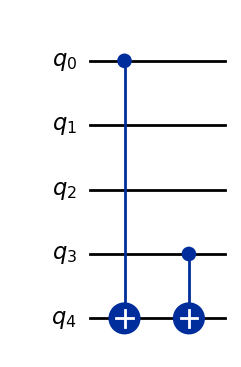

In [107]:
display(bv_query("1001").draw(output="mpl"))

## Bernstein-Vazirani Circuit Local Implementation

Using the *compile_bv_circuit* function defined in the previous notebooks, we can create a new function that runs the Deutsch-Jozsa circuit on the new one.

In [108]:
def bv_algorithm(function: QuantumCircuit) -> str:
    # Executes the Bernstein-Vazirani algorithm for a given function.
        
    qc: QuantumCircuit = compile_bv_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

In [109]:
display(bv_algorithm(bv_query("1001")))

'1001'

## Dinamic Demonstration

Finally, we can create a dynamic demonstration to visualize how the Bernstein-Vazirani algorithm works for different hidden strings.

In [110]:
VERDE = "\033[92m"
ROJO = "\033[91m"
RESET = "\033[0m"

In [111]:
def dynamic_local_demostration(n_qubits):
    # Dynamic demonstration of the Bernstein-Vazirani algorithm for a given number of qubits.
    print(f"\n--- TRYING BERNSTEIN-VAZIRANI WITH SIZE N = {n_qubits} ---")
    
    real_secret: str = "".join([str(random.randint(0, 1)) for _ in range(n_qubits)])
    print(f"Random Real Secret: {real_secret}")

    oracle: QuantumCircuit = bv_query(real_secret)

    quantum_result: str = bv_algorithm(oracle)

    print(f"Quantum Algorithm Result:  {quantum_result}")

    if real_secret == quantum_result:
        print(f"{VERDE}SUCCESS! The algorithm found the secret in just 1 attempt.{RESET}")
    else:
        print(f"{ROJO}FAILURE.{RESET}")

In [112]:
dynamic_local_demostration(3)
dynamic_local_demostration(6)
dynamic_local_demostration(12)


--- TRYING BERNSTEIN-VAZIRANI WITH SIZE N = 3 ---
Random Real Secret: 110
Quantum Algorithm Result:  110
SUCCESS! The algorithm found the secret in just 1 attempt.

--- TRYING BERNSTEIN-VAZIRANI WITH SIZE N = 6 ---
Random Real Secret: 011111
Quantum Algorithm Result:  011111
SUCCESS! The algorithm found the secret in just 1 attempt.

--- TRYING BERNSTEIN-VAZIRANI WITH SIZE N = 12 ---
Random Real Secret: 000100011101
Quantum Algorithm Result:  000100011101
SUCCESS! The algorithm found the secret in just 1 attempt.


## Bernstein-Vazirani Circuit Using Remote IBM Quantum Devices

### Libraries Importation
We need to import the necessary libraries from Qiskit and IBM Quantum to run our Bernstein-Vazirani algorithm on real quantum hardware.

In [113]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

### IBM Quantum Service Setup

To run our quantum circuit on real IBM Quantum devices, we need to set up the IBM Quantum service using our API token. This will allow us to access the quantum backends available on the IBM Quantum cloud platform.

In [114]:
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum_platform",
#     token="TOKEN_HERE",
#     overwrite=True,
# )

We will select the least busy backend that meets our requirements (operational, not a simulator, and with the number of qubits needed in our circuit).

In [115]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=7)
print(f"Dispositivo seleccionado: {backend.name}")

qiskit_runtime_service.__init__:WARNING:2026-01-11 14:01:49,550: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-11 14:01:50,086: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-11 14:01:52,445: Using instance: open-instance, plan: open


Dispositivo seleccionado: ibm_fez


Now, we can run the Bernstein-Vazirani algorithm on real quantum devices.

For this, we are going to use the last implementation recommended for IBM:
- `PassManager:` Using the PassManager for traspile our circuit to a ISA (Instruction Set Architecture) compatible with the selected backend.
- `SamplerV2:` Using the SamplerV2 to execute the circuit on the selected backend.

In [ ]:
def dynamic_real_demostration(n_qubits, backend, CACHE_FILE='bernstein_vazirani_cache.json'):
    # Dynamic demonstration of the Bernstein-Vazirani algorithm on real IBM
    # Quantum hardware for a given number of qubits.
    print(
        f"\n--- TRYING BERNSTEIN-VAZIRANI ON REAL HARDWARE WITH SIZE N = {n_qubits} ---"
    )

    real_secret: str = "".join([str(random.randint(0, 1)) for _ in range(n_qubits)])
    print(f"Random Real Secret: {real_secret}")

    oracle: QuantumCircuit = bv_query(real_secret)
    circuito_bv: QuantumCircuit = compile_bv_circuit(oracle)

    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpiled_isa_circuit = pass_manager.run(circuito_bv)
    sampler = Sampler(mode=backend)

    job = sampler.run([transpiled_isa_circuit], shots=1024)
    print(f"Job {job.job_id()} submitted to backend {backend.name}.")

    result = job.result()

    # using integers in the QuantumCircuit constructor assigns 'c' to classical registers
    counts = result[0].data.c.get_counts()

    final_result = max(counts, key=counts.get)

    print(f"Quantum Result (Frequent): {final_result}")
    print(f"Complete Counts: {counts}")

    if real_secret == final_result:
        print(
            f"{VERDE}SUCCESS! The algorithm found the secret in just 1 attempt.{RESET}"
        )
    else:
        print(f"{ROJO}FAILURE.{RESET}")
  
    # We save the results to a cache file
    save_data = { "counts": counts, "secret": real_secret}
    with open('results/' + CACHE_FILE, 'w') as f: 
      json.dump(save_data, f)

Finally, we can compare the result obtained from the real quantum hardware with the expected secret string.

In [ ]:
dynamic_real_demostration(3, backend, 'bernstein_vazirani_cache_3qubits.json')
dynamic_real_demostration(5, backend, 'bernstein_vazirani_cache_5qubits.json')


--- TRYING BERNSTEIN-VAZIRANI ON REAL HARDWARE WITH SIZE N = 3 ---
Random Real Secret: 010
Job d5hqqjcpe0pc73amoi9g submitted to backend ibm_fez.
Quantum Result (Frequent): 010
Complete Counts: {'010': 1004, '000': 20}
SUCCESS! The algorithm found the secret in just 1 attempt.

--- TRYING BERNSTEIN-VAZIRANI ON REAL HARDWARE WITH SIZE N = 5 ---
Random Real Secret: 11101
Job d5hqqkspe0pc73amoibg submitted to backend ibm_fez.
Quantum Result (Frequent): 11101
Complete Counts: {'11101': 882, '01101': 28, '11100': 34, '10101': 20, '00001': 11, '00101': 11, '00000': 7, '10001': 7, '11001': 19, '10000': 2, '01001': 3}
SUCCESS! The algorithm found the secret in just 1 attempt.


As we can see, the algorithm successfully finds the hidden string in just one attempt, demonstrating the efficiency of the Bernstein-Vazirani algorithm on real quantum hardware.

Also we can observe that the results are not perfect, thats because of the noise and errors present in current quantum devices. But still, the algorithm manages to find the correct secret string with a high probability.